58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729289760.409624      97 service.cc:145] XLA service 0x7f5510008760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729289760.409666      97 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729289760.409670      97 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/901 ━━━━━━━━━━━━━━━━━━━━ 1:23 93ms/step - accuracy: 0.1198 - loss: 2.2638 

I0000 00:00:1729289764.702604      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.2868 - loss: 1.7685
Epoch 1: val_accuracy improved from -inf to 0.37617, saving model to best_model_vgg.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 194s 208ms/step - accuracy: 0.2869 - loss: 1.7684 - val_accuracy: 0.3762 - val_loss: 1.5992 - learning_rate: 0.0010
Epoch 2/15
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3376 - loss: 1.6642
Epoch 2: val_accuracy improved from 0.37617 to 0.39074, saving model to best_model_vgg.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.3376 - loss: 1.6642 - val_accuracy: 0.3907 - val_loss: 1.5678 - learning_rate: 0.0010
Epoch 3/15
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3542 - loss: 1.6398
Epoch 3: val_accuracy improved from 0.39074 to 0.39499, saving model to best_model_vgg.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.3542 - loss: 1.6398 - val_accuracy: 0.3950 - val_loss: 1.5597 - learning_rate: 0.0010
Epoch 4/15
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s

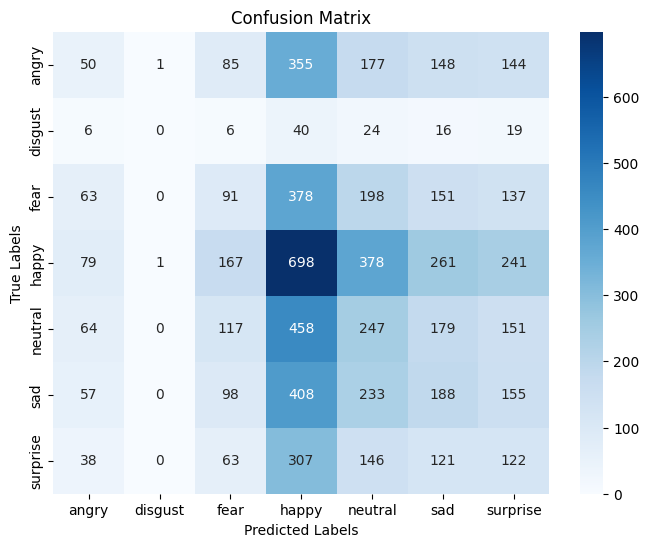

              precision    recall  f1-score   support

       angry       0.14      0.05      0.08       960
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.09      0.11      1018
       happy       0.26      0.38      0.31      1825
     neutral       0.18      0.20      0.19      1216
         sad       0.18      0.17      0.17      1139
    surprise       0.13      0.15      0.14       797

    accuracy                           0.20      7066
   macro avg       0.15      0.15      0.14      7066
weighted avg       0.18      0.20      0.18      7066



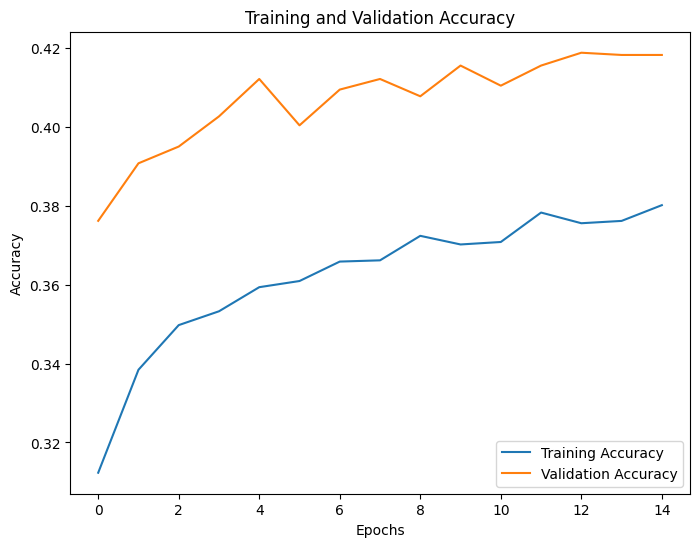

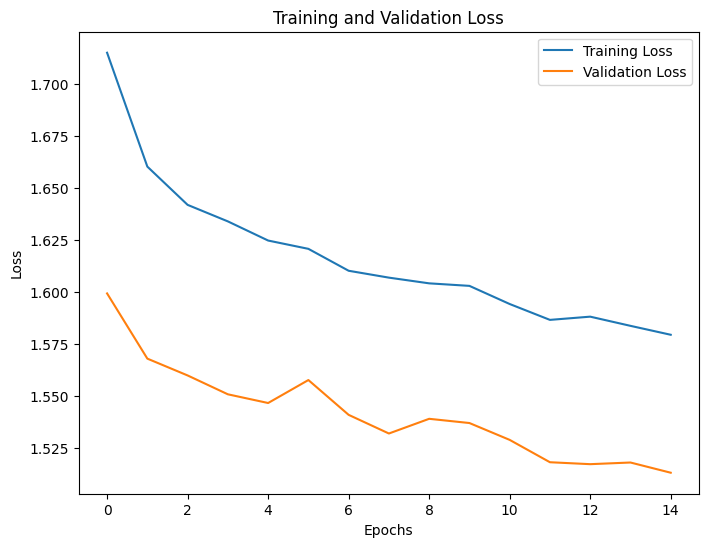

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define the paths to the dataset (Make sure the paths are correctly set according to your system)
train_dir = '/kaggle/input/face-expression-recognition-dataset/images/train'
validation_dir = '/kaggle/input/face-expression-recognition-dataset/images/validation'

# Define the image size and batch size
IMG_SIZE = 48
BATCH_SIZE = 32

# Load the VGG16 model, excluding the top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the convolutional base
vgg_base.trainable = False

# Build the model
model = Sequential()
model.add(vgg_base)
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout to avoid overfitting
model.add(Dense(7, activation='softmax'))  # Output layer for 7 emotion categories

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Data augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of tensor image data from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

# Callbacks for model saving, early stopping, and learning rate reduction
checkpoint = ModelCheckpoint('best_model_vgg.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

callbacks = [checkpoint, early_stop, reduce_lr]

# Train the model
history = model.fit(train_generator, epochs=15, validation_data=validation_generator, callbacks=callbacks)

# Evaluate the model on the validation set
validation_loss, validation_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_acc}")

# Generate predictions for validation set
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualization of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report to evaluate precision, recall, F1 score
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [9]:
import os

# Base directory where the dataset is stored
base_dir = '/kaggle/input/face-expression-recognition-dataset/images'

# Check the available subdirectories
print("Subdirectories in the dataset:", os.listdir(base_dir))


Subdirectories in the dataset: ['validation', 'images', 'train']


In [13]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model  # Include load_model here
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the best model after training
best_model = load_model('best_model_vgg.keras')

# Evaluate the model on the validation set
validation_loss, validation_acc = best_model.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_acc}")


221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.4258 - loss: 1.5134
Validation Accuracy: 0.41876593232154846


In [14]:
# Generate predictions for validation set
y_true = validation_generator.classes
y_pred = np.argmax(best_model.predict(validation_generator), axis=1)


221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step


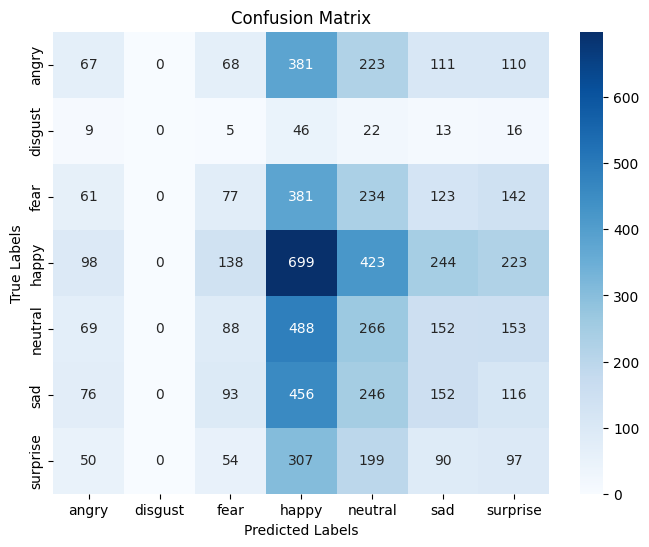

In [15]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualization of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [16]:
# Classification report to evaluate precision, recall, F1 score
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))


              precision    recall  f1-score   support

       angry       0.16      0.07      0.10       960
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.08      0.10      1018
       happy       0.25      0.38      0.31      1825
     neutral       0.16      0.22      0.19      1216
         sad       0.17      0.13      0.15      1139
    surprise       0.11      0.12      0.12       797

    accuracy                           0.19      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.18      0.19      0.18      7066



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


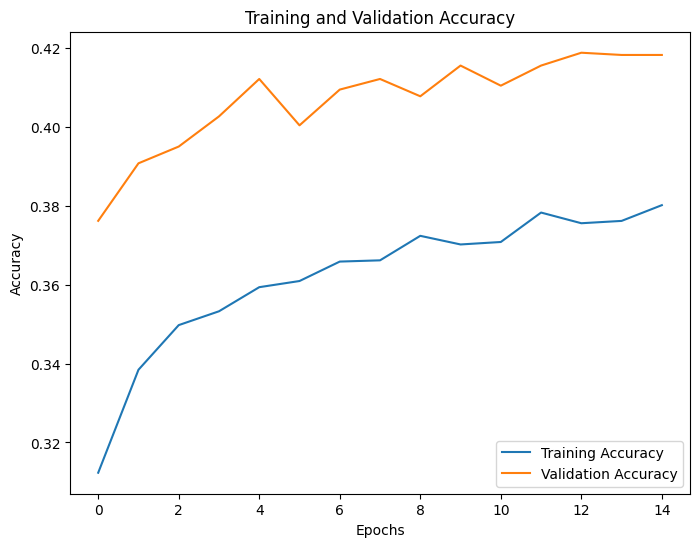

In [17]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


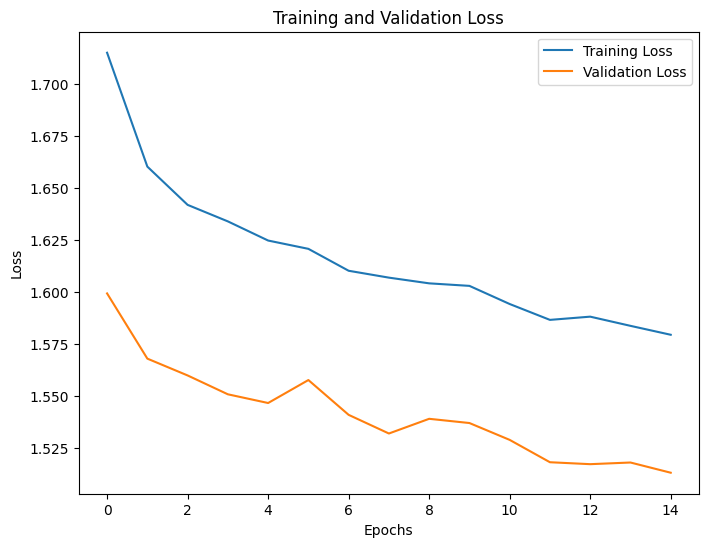

In [18]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [19]:
# Save the final model
best_model.save('final_model_vgg.keras')


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [21]:
history = model.fit(train_generator, epochs=15, validation_data=validation_generator, callbacks=callbacks)


Epoch 1/15
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3845 - loss: 1.5728
Epoch 1: val_accuracy improved from 0.41877 to 0.41933, saving model to best_model_vgg.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.3845 - loss: 1.5728 - val_accuracy: 0.4193 - val_loss: 1.5153 - learning_rate: 0.0010
Epoch 2/15
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3789 - loss: 1.5738
Epoch 2: val_accuracy did not improve from 0.41933
901/901 ━━━━━━━━━━━━━━━━━━━━ 65s 72ms/step - accuracy: 0.3789 - loss: 1.5738 - val_accuracy: 0.4162 - val_loss: 1.5172 - learning_rate: 0.0010
Epoch 3/15
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3896 - loss: 1.5657
Epoch 3: val_accuracy did not improve from 0.41933
901/901 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.3896 - loss: 1.5657 - val_accuracy: 0.4193 - val_loss: 1.5062 - learning_rate: 0.0010
Epoch 4/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3850 - loss: 1.5667
Epoch 4: val_accuracy did no

In [22]:
best_model = load_model('best_model_vgg.keras')


In [23]:
validation_loss, validation_acc = best_model.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_acc}")


221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.4328 - loss: 1.4869
Validation Accuracy: 0.4371638894081116


In [24]:
y_true = validation_generator.classes
y_pred = np.argmax(best_model.predict(validation_generator), axis=1)


221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step


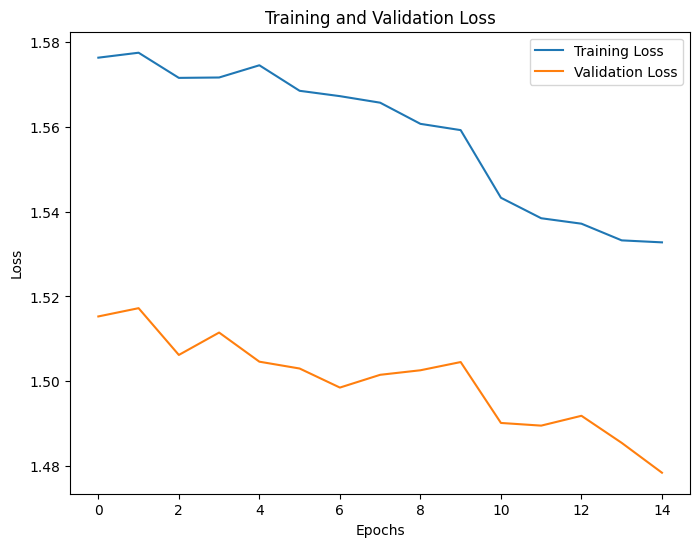

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


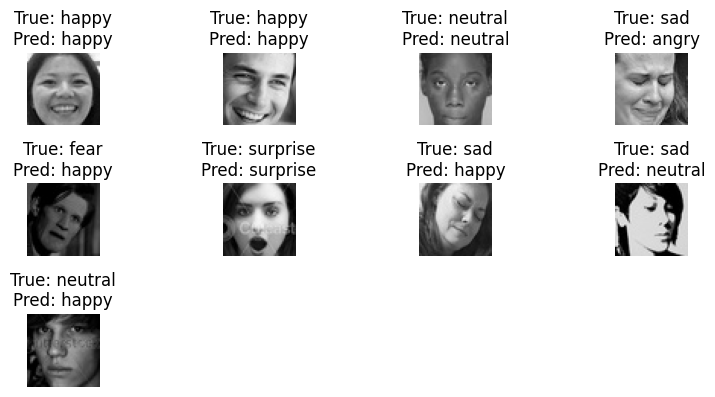

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Extract a batch of images from the validation set using 'next()'
images, labels = next(validation_generator)

# Get the true class indices and class labels from the generator
class_labels = list(validation_generator.class_indices.keys())

# Use the trained model to predict labels for these images
predictions = np.argmax(best_model.predict(images), axis=1)

# Plot some images along with their predicted and true labels
plt.figure(figsize=(8, 8))
for i in range(9):  # Displaying 9 images as an example
    plt.subplot(6, 4, i+1)
    plt.imshow(images[i])
    true_label = class_labels[np.argmax(labels[i])]  # True label
    predicted_label = class_labels[predictions[i]]  # Predicted label
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')  # Remove axes for a cleaner view
plt.tight_layout()
plt.show()


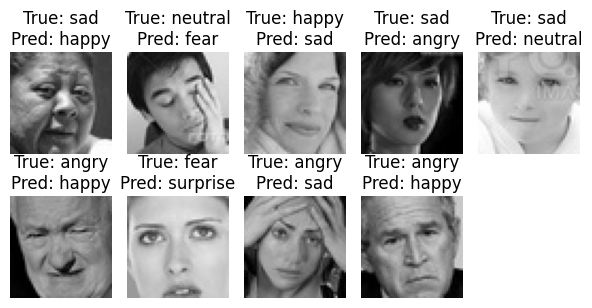

In [46]:
# Find misclassified images
misclassified_indices = np.where(predictions != np.argmax(labels, axis=1))[0]

plt.figure(figsize=(6, 6))
for i, idx in enumerate(misclassified_indices[:9]):  # Display up to 9 misclassified images
    plt.subplot(4, 5, i+1)
    plt.imshow(images[idx])
    true_label = class_labels[np.argmax(labels[idx])]  # True label
    predicted_label = class_labels[predictions[idx]]  # Predicted label
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [29]:
from sklearn.metrics import accuracy_score

# Get the true labels and predicted labels
y_true = np.argmax(labels, axis=1)
y_pred = predictions

# Compute accuracy for each class
for class_label in class_labels:
    class_idx = class_labels.index(class_label)
    class_acc = accuracy_score(y_true[y_true == class_idx], y_pred[y_true == class_idx])
    print(f"Accuracy for {class_label}: {class_acc * 100:.2f}%")


Accuracy for angry: 0.00%
Accuracy for disgust: nan%
Accuracy for fear: 0.00%
Accuracy for happy: 66.67%
Accuracy for neutral: 28.57%
Accuracy for sad: 40.00%
Accuracy for surprise: 50.00%


/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


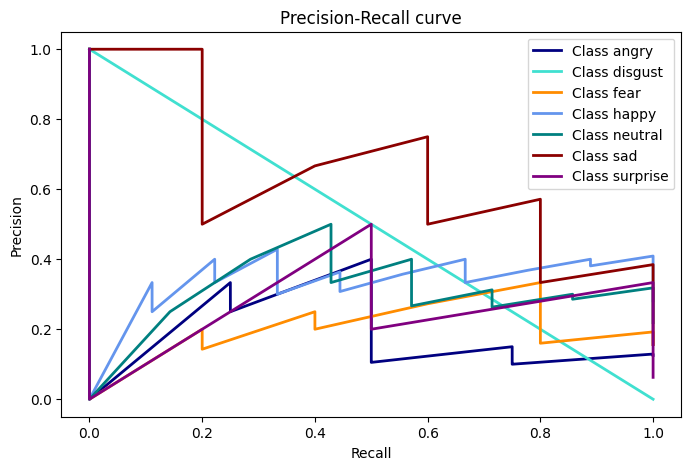

In [44]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the true labels for multi-class precision-recall curve
y_true_bin = label_binarize(y_true, classes=[i for i in range(len(class_labels))])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 5))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'darkred', 'purple'])

for i, color in zip(range(len(class_labels)), colors):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], best_model.predict(images)[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f'Class {class_labels[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc="best")
plt.show()


In [31]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.5  # Reduce learning rate by half after 10 epochs

lr_callback = LearningRateScheduler(lr_scheduler)


In [32]:
# Unfreeze the last few layers of the VGG16 base model
vgg_base.trainable = True
for layer in vgg_base.layers[:-4]:  # Freeze all layers except the last 4
    layer.trainable = False

# Compile and re-train the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train again with fine-tuning
history_fine_tune = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=callbacks)


Epoch 1/10
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4034 - loss: 1.5365
Epoch 1: val_accuracy improved from 0.43716 to 0.45188, saving model to best_model_vgg.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 69s 71ms/step - accuracy: 0.4034 - loss: 1.5364 - val_accuracy: 0.4519 - val_loss: 1.4419 - learning_rate: 1.0000e-05
Epoch 2/10
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4292 - loss: 1.4802
Epoch 2: val_accuracy improved from 0.45188 to 0.46575, saving model to best_model_vgg.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.4292 - loss: 1.4802 - val_accuracy: 0.4658 - val_loss: 1.4077 - learning_rate: 1.0000e-05
Epoch 3/10
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4416 - loss: 1.4496
Epoch 3: val_accuracy improved from 0.46575 to 0.47948, saving model to best_model_vgg.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 60s 66ms/step - accuracy: 0.4416 - loss: 1.4496 - val_accuracy: 0.4795 - val_loss: 1.3699 - learning_rate: 1.0000e-05
Epoch 4/10
900/901 

In [34]:
# Save the model weights
model.save_weights('vgg16_fine_tuned_model.weights.h5')

# Load the saved weights later
model.load_weights('vgg16_fine_tuned_model.weights.h5')


In [35]:
model.save('vgg16_fine_tuned_model.h5')


In [36]:
from tensorflow.keras.models import load_model
model = load_model('vgg16_fine_tuned_model.h5')
